# ADS 509 Sentiment Assignment
## Stephen Kuc

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [179]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from sklearn import preprocessing

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords


sw = stopwords.words("english")

In [221]:
# Add any additional import statements you need here

import nltk
from nltk.tokenize import word_tokenize

import seaborn as sns


In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/steph/OneDrive/Documents/USD/ADS509/Mod2/"
data_location_mine = "/Users/steph/OneDrive/Documents/GitHub/ads509-api-scrape/" 

# Going to utilize the sample data provided for this 

twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data

# this for Tom Petty and FT data

lyric_path_ft = data_location_mine + lyrics_folder

lyric_dict_ft = {"artist": [], "song_name": [], "lyrics": []}

for artist_folder in os.listdir(lyric_path_ft):
    artist_path = lyric_path_ft + artist_folder
    for file in os.listdir(artist_path):
        if file.endswith(".txt"):
            file_path = f"{artist_path}/{file}"
            with open(file_path, 'r') as f:
                lyrics = f.read()
                song_name = file.split("_")[1].split(".")[0] # take just song title from file name
                
                # adding data to dictionary
                lyric_dict_ft['artist'].append(artist_folder)
                lyric_dict_ft['song_name'].append(song_name)
                lyric_dict_ft['lyrics'].append(lyrics)


In [5]:
# Read in the twitter data
# just for cher and robyn


twit_path = data_location + twitter_folder

twit_dict_cr = {"artist": [], "description": []}

for file in os.listdir(twit_path):
    if file.endswith('_data.txt'):
        # saving artist name from folder name
        artist = file.split('_')[0]
        
        # saving follower_path
        file_path = twit_path + file
        with open(file_path, 'r', encoding = "utf8") as f:
            for line in f:
                fields = line.strip().split("\t")
                description = fields[-1] # description should be last field based on last assignment instrs.
    
                # adding data to dictionary
                twit_dict_cr['artist'].append(artist)
                twit_dict_cr['description'].append(description)

In [145]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# positive words

with open("positive-words.txt", "r", encoding = "utf-8") as pos:
    pos_lines = pos.readlines()

# negative words

with open("negative-words.txt", "r") as neg:
    neg_lines = neg.readlines()
    
# utilizing blueprint code from text book

pos_score = 1
neg_score = -1
word_dict = {}


for word in pos_lines:
    word = word.rstrip('\n') # cleaning data first few lines
    if len(word.split(" ")) > 1:
        pass
    elif word in [";", ""]:
        pass
    else:
        word_dict[word] = pos_score

for word in neg_lines:
    word = word.rstrip('\n') # cleaning data first few lines
    if len(word.split(" ")) > 1:
        pass
    elif word in [";", ""]:
        pass
    else:
        word_dict[word] = neg_score

In [209]:
lyrics_df = pd.DataFrame.from_dict(lyric_dict_ft)

lyrics_df['lyrics']= lyrics_df['lyrics'].astype(str)

# cleaning data from last assignment
lyrics_df['lyrics'] = [re.sub("u2019", "'", s) for s in lyrics_df['lyrics']]
lyrics_df['lyrics'] = [re.sub("u2013", " ", s) for s in lyrics_df['lyrics']]
lyrics_df['lyrics'] = [re.sub("[^\w\s]", "", s) for s in lyrics_df['lyrics']]

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [170]:
# creating function for sentiment score

def sentiment_score(text):
    s_score = 0
    lower = text.lower()
    bag = word_tokenize(lower)
    for w in bag:
        if w in word_dict:
            s_score += word_dict[word]
    return s_score / len(bag)


In [211]:
lyrics_df['sentiment_score'] = lyrics_df['lyrics'].apply(sentiment_score)

In [212]:
lyrics_df[['artist', 'song_name', 'sentiment_score']].sample(5)

,artist,song_name,sentiment_score
19,frankturner,wisdomteeth,-0.084848
3,frankturner,fathersday,-0.076023
9,frankturner,oncewewereanarchists,-0.095238
25,tompetty,fooledagainidontlikeit,-0.161458
8,frankturner,mykingdomforahorse,-0.053254


In [213]:
# like in the book, let's scale the scores to be between -1 and 1

lyrics_df['sentiment_score_scaled'] = preprocessing.scale(lyrics_df['sentiment_score'])

In [214]:
# now to group by artist and see the higher scores

lyrics_df.groupby('artist').agg({'sentiment_score_scaled': 'mean'})

,sentiment_score_scaled
artist,
frankturner,0.116708
tompetty,-0.116708


In [217]:
# finding songs with bottom 3 sentiment score

# allowing it to show all lyrics
pd.set_option('display.max_colwidth', None)

ft_bot3 = lyrics_df[lyrics_df['artist'] == "frankturner"].sort_values("sentiment_score").head(3)
tp_bot3 = lyrics_df[lyrics_df['artist'] == "tompetty"].sort_values("sentiment_score").head(3)

# finding songs with top 3 sentiment score

ft_top3 = lyrics_df[lyrics_df['artist'] == "frankturner"].sort_values("sentiment_score", ascending = False).head(3)
tp_top3 = lyrics_df[lyrics_df['artist'] == "tompetty"].sort_values("sentiment_score", ascending = False).head(3)


# Displaying Frankturner's scores and lyrics
display(ft_bot3, ft_top3)

,artist,song_name,lyrics,sentiment_score,sentiment_score_scaled
6,frankturner,loveiresong,Frank Turner Love Ire Song Lyrics AZLyricscom nn Well a teacher of mine once told me That life was just a list of disappointments and defeats And you could only do your best And I said Well thats a fucking copout youre just washed up and youre tired And when I get to your age well I wont be such a coward But these days I sit at home known to shout at my TV And Punk Rock didnt live up to what Id hoped that it could be And all the things that I believed with all my heart when I was young Are just coasters for beers and clean surfaces for drugs And I packed all my pamphlets with my bibles at the back of the shelf Well it was bad enough the feeling and the first time it hit When you realised your parents had let the world all go to shit And that the values and ideals for which many had fought and died Had been killed off in the committees and left to die by the wayside But it was worse when we turned to the kids on the left And got let down again by some poor excuse for protest Yeah by idiot fucking hippies in 50 different factions Who are locked inside some kind of 60s battle reenactment And I hung up my banner in disgust and I head for the door Oh but once we were young and we were crass enough to care But I guess you live and learn we wont make that mistake again no Oh but surely just for one day we could fight and we could win And if only for a little while we could insist on the impossible Well weve been a good few hours drinking So Im going to say what everyones thinking If were stuck on this ship and its sinking Then we might as well have a parade Cause if its still going to hurt in the morning And a better plans yet to get forming Then wheres the harm spending an evening In manning the old barricades So come on old friends to the streets Lets be 1905 but not 1917 Lets be heroes lets be martyrs lets be radical thinkers Who never have to test drive the least of their dreams Lets divide up the world into the damned and the saved And then ride to the valley like the old light brigade And straighten our backs and we wont be afraid And theyll celebrate our deaths with a national parade So come on lets be young lets be crass enough to care Lets refuse to live and learn lets make all our mistakes again yes And then darling just for one day yeah we can fight and we can win And if only for a little while we could insist on the impossible Leave the mourning to the morning Yeah pain can be killed With aspirin tablets and vitamin pills But memories of hope and of glorious defeat Are a little bit harder to beat,-0.112403,-0.867186
7,frankturner,musttryharder,Frank Turner Must Try Harder Lyrics AZLyricscom nn Mother loves me still despite My failing health and lack of drive Shame on me I could be so much better than I am Songs unfinished post unopened Clothes unwashed and vows now broken Shame on me I could be so much better than I am If I could just relax then I could admit That I dont know what I want but this is not it If I could just recall the dreams I had as a kid If I could just relax if I could let my guard slip Id be such a winner,-0.096154,-0.462273
9,frankturner,oncewewereanarchists,Frank Turner Once We Were Anarchists Lyrics AZLyricscom nn The demonstrations got boring Well it was obvious that the government was ignoring us Its hard to drag yourself through empty streets On an empty stomach and no sleep The shortcomings got clearer As the price we paid got dearer and dearer Its supposed to be a case of give and take Well I was feeling the give and making a mistake And Ive heard it said that the unexamined life Isnt much worth living and Im sure theyre right But its hard to keep on fighting the good fight When no one else seems bothered yeah When no ones on your side Ive got friends who are bankers And its an easy rhyme to call them wankers But I must say I envy the way that they live In a style thats all take and no give While Im playing

,artist,song_name,lyrics,sentiment_score,sentiment_score_scaled
10,frankturner,photosynthesis,Frank Turner Photosynthesis Lyrics AZLyricscom nn 12123 Well I guess I should confess that I am starting to get old All the latest music fads all passed me by and left me cold All the kids are talking slang I wont pretend to understand All my friends are getting married mortgages and pension plans And its obvious my angry adolescent days are done And Im happy and Im settled in the person Ive become But that doesnt mean Im settled up and sitting out the game Time may change a lot but some things may stay the same And I wont sit down And I wont shut up And most of all I will not grow up And I wont sit down And I wont shut up And most of all I yeah I wont grow up Oh maturitys a wrapped up package deal so it seems And ditching teenage fantasy means ditching all your dreams All your friends and peers and family solemnly tell you you will Have to grow up be an adult yeah be bored and unfulfilled Oh when no ones yet explained to me exactly whats so great About slaving 50 years away on something that you hate about meekly shuffling down the path of mediocrity Well if thats your road then take it but its not the road for me And I wont sit down And I wont shut up And most of all I will not grow up And I wont sit down And I wont shut up And most of all I yeah I wont grow up And I wont sit down And I wont shut up And most of all I will not grow up And if all you ever do with your life Is photosynthesize Then you deserve every hour of these sleepless nights That you waste wondering when youre gonna die Now Ill play and you sing The perfect way for the evening to begin Now Ill play and you sing The perfect way for the evening to begin And I wont sit down And I wont shut up And most of all yeah I wont grow up And I wont sit down And I wont shut up And most of all I will not grow up And I wont sit down And I wont shut up And most of all I will not grow up,-0.040302,0.929488
0,frankturner,adecentcupoftea,Frank Turner A Decent Cup Of Tea Lyrics AZLyricscom nn It hadnt been a day when everything had turned out right She called me up and asked me to come over in the night To make her cups of tea and listen quietly as she starts To list the latest list of bastards who have trampled on her heart I see her in the nightclubs I see her in the bars At rooftop afterparties or crammed into friends cars And we talk about the weather and how she drowns her pain in drink And I nod and never ever dare to tell her what I think She summers by my seas But winters without me And she cries into her tea That shes secretly lonely And oh me what am I to do Its obvious to me But she never seems to see That its not about the days when everything has turned out right No its more about the moments when she calls me in the night To make her cups of tea and wash the weary worries from her head And then to draw the pain out slowly as I put her into bed And I slip this information Into all our conversations But she never seems to listen And she never seems to see,-0.046083,0.785440
15,frankturner,theladiesoflondontown,Frank Turner The Ladies Of London Town Lyrics AZLyricscom nn Theres so many beautiful girls in here tonight I can hardly stand it Where do they go during the day Who the hell do they go home with at the end of the night I dont understand it They never go home with me You dance as if youre hours away from death Youre wearing too much makeup and showing too much flesh And you smile a smile to take away my breath Because tonight and only tonight you know youre the best The ladies of London town Go flowing through these streets like water Running little streams down to the river They wash the dirty ground they sweep me off my feet But like an English summer theyll soon be gone forever Ive seen you trawling Camden at 4am Outside of the clubnight Deciding whose house will hold a freeforall Ive followed you back to mansions and Ive met all your friends Under the streetlights

In [219]:
# displaying Tom Petty's

display(tp_top3, tp_bot3)

,artist,song_name,lyrics,sentiment_score,sentiment_score_scaled
28,tompetty,ineedtoknow,Tom Petty And The Heartbreakers I Need To Know Lyrics AZLyricscom nn Well the talk on the street says you might go solo Good friend of mine saw you leavin by your back door I need to know I need to know I need to know I need to know If you think youre gonna leave then you better say so I need to know I need to know I need to know I need to know Because I dont know how long I can hold on If youre making me wait if youre leadin me on I need to know I need to know I need to know I need to know Who wouldve thought that youd fall for his line All of a sudden its me on the outside I need to know I need to know I need to know I need to know If you think youre gonna leave then you better say so I need to know I need to know I need to know I need to know Because I dont know how long I can hold on If youre making me wait if youre leadin me on I need to know I need to know I need to know I need to know Baby I need to know I need to know I need to know I need to know If you think youre gonna leave then you better say so I need to know I need to know I need to know I need to know Because I dont know how long I can hold on If youre making me wait if youre leadin me on I need to know I need to know I need to know I need to know Baby I need to know,-0.023490,1.348433
36,tompetty,rockinaroundwithyou,Tom Petty And The Heartbreakers Rockin Around With You Lyrics AZLyricscom nn Why be lonely Why be blue You got me babe I got you And I cant stop thinkin bout you How I dig rockin around with you I was waiting You came through You knew no one else will do And I cant stop thinkin bout you How I dig rockin around with you You know I dig rockin around You know I dig rockin around You know I dig rockin around,-0.023810,1.340469
23,tompetty,babysarocknroller,Tom Petty And The Heartbreakers Babys A Rock N Roller Lyrics AZLyricscom nn My baby is a rock n roller My baby is a rock n roller Yeah thats all that she ever wants to be So why you trying to come on with this sophistication She dont wanna know about your education Man she dont care about the United Nations My babys gone on a rhythm sensation Thats all she ever wants to be My baby is a rock n roller Well she cant take them stupid friends of yours She aint going to go through all of that no more She dont wanna be no dentist assistant Man she got the rhythm and she cant resist it Thats all she ever wants to be My baby is a rock n roller My baby is a rock n roller My baby is a rock n roller My baby is a rock n roller,-0.025641,1.294830


,artist,song_name,lyrics,sentiment_score,sentiment_score_scaled
35,tompetty,restless,Tom Petty And The Heartbreakers Restless Lyrics AZLyricscom nn I dont need to belong to no one I dont belong at all I got my face in a corner Got my back to the wall Yeah pretty baby Im restless restless Restless through and through Im restless restless You look restless too Im a hairtrigger lover And I cant face up to nothing Im impatient with the wind But Im waiting here for something Pretty baby Im restless restless Restless through and through Im restless restless You look restless too Restless sleep twisted dreams Moving targets silent screams Restless city restless street Restless you restless me Im a face out the window Im a black satin sheet And I cant stay warm I stay out in the street Yeah pretty baby Im restless restless Restless through and through Im restless restless You look restless too,-0.227586,-3.737424
25,tompetty,fooledagainidontlikeit,Tom Petty And The Heartbreakers Fooled Again I Dont Like It Lyrics AZLyricscom nn Strange voice on the telephone Tellin me I better leave you lone Why dont somebody say whats going on Uh oh I think I been through this before Looks like Im the fool again Looks like Im the fool again I dont like it I dont like it You never said you had no number two I need to know about it if you do If two is one I might as well be three Its good to see you think so much of me Looks like Im the fool again Looks like Im the fool again I dont like it I dont like it Look out You never said you had no number two I need to know about it if you do If two is one I might as well be three Its good to see you think so much of me Looks like Im the fool again Looks like Im the fool again I dont like it I dont like it Look out I dont like it I dont like it I dont like it,-0.161458,-2.089589
27,tompetty,hurt,Tom Petty And The Heartbreakers Hurt Lyrics AZLyricscom nn I walked to the window turned out the light Looked at the city went back through the night Yeah I stood in the darkness stood all alone Thank God for California thank God Im going home Thats right you hurt me baby hurt me good Hurt me like no one else ever could Cut me down the middle face down in the dirt And we both know its too late to save it Bet you feel proud about it baby You taught me how to hurt thats right DC10 1045 Halfway to LA red in the eyes You might be the devil might just be his friend It dont make no difference you aint gettin me again Thats right you hurt me baby hurt me good Hurt me like no one else ever could Cut me down the middle face down in the dirt And we both know its too late to save it Bet you feel proud about it baby You taught me how to hurt thats right Thats right Hurt me Cut me down the middle Thats right,-0.153439,-1.889760


### Questions

#### Q: Overall, which artist has the higher average sentiment per song? 

A: For these first 20 songs of each artist's career, Frank Turner has a slightly higher average sentiment per songs than Tom Petty. Honestly, it's pretty interesting that Frank's are more positive, where I would think he is slightly more negative, especially in his earlier days. There's also a chance that since Tom uses more frequent words, that his words fell more into the overall lexicon than Franks, and were then scored more often.

---

### Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

(Code and printed lyrics are above)

A: Frank Turner:
    
   3 highest: "Photosynthesis", "A Decent Cup of Tea", and "The Ladies of London Town"
   
   3 Lowest: "Love, Ire and Song", "Must Try Harder", and "Once we were Anarchists."
   

Knowing these songs, Photosynthesis makes sense to be one of the more positive songs. Althouogh, when looking at the lyrics, there are mentions of death, wasted time, sleepless nights, and others; but it does have a tinge of positive with words like marriage, friends, family, dreams, and negation of possibly bad things, which isn't taken into account with the lexicon approach ("I won't shut up", "I won't sit down").
 
On the negative side, "Love, Ire, and Song" is a song about growing up, getting let down, and being disappointed at how the world turned out to be; yet it does end positively, and listening to it fully, it could be considered a slightly optimistic song (brilliant song, IMO). Since the majority of the song is negative, then it has an overall negative rating. There are many negative words like "disgust", "disappointment", "defeat", "killed", "idiot", "sinking", "pain", and the list goes on, are all included. There are swears as well. This reminds me of the "thwarted expectations" example given in this week's presentation, except as opposite. 

Overall, these songs didn't seem to range too high positively or too low negative overall. This makes sense to me, as his songs tend to be more from a realist type of perspective, that while most may be negative to some degree, there is some optimism taken out in the end.
   

---

### Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 


(Code and printed lyrics are above)

A: Tom Petty:
    
   3 highest: "I Need To Know", "Rockin Around with You", and "Baby's a Rock and Roller"
   3 lowest: "Restless", Fooled Again", and "hurt"
   
Tom's lyrics are much more rock and rolly, and more simple than Frank's. There are a lot of repeated words -- all these songs utilize the song name in the chorus. The positive song titles seem to be a bit more positive, while negative are more negative, so that usage must be driving the score a bit. 

"I need to know", though, is perhaps a more negative song in the end, as it's about someone possibly leaving a relationship. The rest of the positive songs do seem like positive songs, with a lot of use of the word "babe" or "baby". Still their overall scores are in the negative.

The low songs all make sense, at least in terms of how the lexicon works. "fooled again" uses the word "Fool" a lot, although the verses are a bit sarcastic (seem positive, but are negative), but since this doesn't take context into situation, as there is a lot of negation. "Hurt" uses the word "Hurt" a lot, as mentioned; aside from these song titles, it's hard to see other words that are strongly positive or negative.

---

### Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

Below are the distributions; both for the raw sentiment score, and for scaled


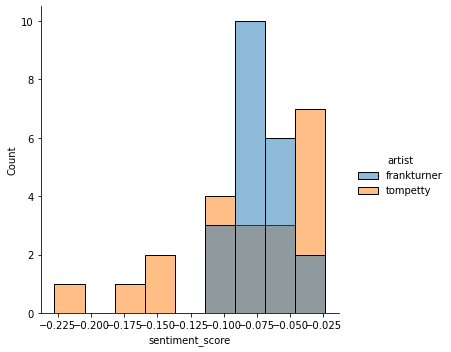

In [222]:
# plotting with raw sentiment score

sns.displot(lyrics_df, x = "sentiment_score", hue = "artist")

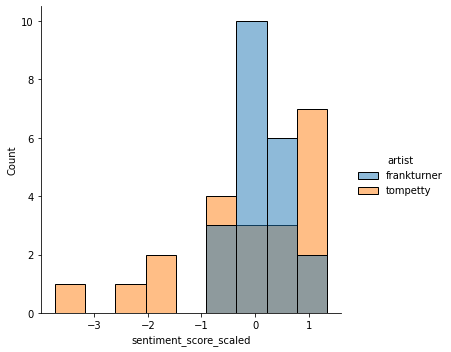

In [224]:
# plotting with scaled sentiment score

sns.displot(lyrics_df, x = "sentiment_score_scaled", hue = "artist")

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [279]:
import random

pos_emojis = ["joy", "heart", "heart_eyes", "blush", "kissing_heart", "fire", "relaxed",
             "+1", "sparkles", "sunglasses", "purple_heart", "blue_heart"]

neg_emojis = ["pensive", "unamused", "weary", "broken_heart", "cry", "disappointed",
              "expressionless", "confused", "rage", "grimacing", "angry", "confounded"]

pos_emoji = []
neg_emoji = []

size = len(pos_emojis)

def getEmoji():
    sizeOfEmoji = random.randrange(12) + 4
    emojiToAns = ''
    for x in range(sizeOfEmoji):
        full_emoji = ':' + pos_emojis[random.randrange(size)] + ':'
        emoji_to_add = emoji.emojize(full_emoji, use_aliases = True)
        emojiToAns += emoji_to_add
    return emojiToAns


In [301]:
pos_emoj = ["joy", "heart", "heart_eyes", "blush", "kissing_heart", "fire", "relaxed",
             "+1", "sparkles", "sunglasses", "purple_heart", "blue_heart"]

neg_emoj = ["pensive", "unamused", "weary", "broken_heart", "cry", "disappointed",
              "expressionless", "confused", "rage", "grimacing", "angry", "confounded"]

pos_emoji = []
neg_emoji = []

for i in pos_emojis:
    emo = ':' + i + ':'
    emo = emoji.emojize(emo)
    pos_emoji.append(emo)

In [316]:
# creating sets of positive and negative emojis
# 12 emojis each set
# using ones that don't seem neutral, or could be used both ways

import emoji

pos_emojis = [emoji.emojize(':joy:'), # laughing, crying face
              emoji.emojize(':heart:'), # heart
              emoji.emojize(':heart_eyes:'), # heart-eyes
              emoji.emojize(':blush:'), # smiling, blushing face
              emoji.emojize(':kissing_heart:'), # kissing face
              emoji.emojize(':fire:'), # fire emoji
              emoji.emojize(':relaxed:'), # another smiling, blushing , relaxed face
              emoji.emojize(':+1:'), # thumbs up emoji
              emoji.emojize(':sparkles:'), # four stars/sparkles
              emoji.emojize(':sunglasses:'), #smiling face with sunglasses
              emoji.emojize(':purple_heart:'), # purple heart
              emoji.emojize(':blue_heart:')] # blue heart


neg_emojis = [emoji.emojize(':pensive:'), # pensive, remorseful face
             emoji.emojize(':unamused:'),
             emoji.emojize(':weary:'),
             emoji.emojize(':broken_heart:'),
              emoji.emojize(':cry:'),
              emoji.emojize(':disappointed:'),
              emoji.emojize(':expressionless:'),
              emoji.emojize(':confused:'),
              emoji.emojize(':rage:'), # red, angry face
              emoji.emojize(':grimacing:'),
              emoji.emojize(':angry:'),
              emoji.emojize(':confounded:')]
              
            

In [319]:
# utilizing similar code used in last question

pos_score = 1
neg_score = -1
emoji_dict = {}


for emo in pos_emojis:
    emoji_dict[emo] = pos_score

for emo in neg_emojis:
    emoji_dict[emo] = neg_score

In [320]:
# creating a function to extract emojis

def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI['en'])

In [321]:
# creating field with just emojis

descr_emojis = []

for i in tweet_df['description']:
    descr_emo = extract_emojis(i)
    descr_emojis.append(descr_emo)



In [346]:
# adding emojis to tweet_df

tweet_df['emojis'] = descr_emojis

In [331]:
# creating function for sentiment score

def emoji_score(emojis):
    e_score = 0
    bag = [x for x in emojis]
    for e in bag:
        if e in emoji_dict:
            e_score += emoji_dict[e]
    return e_score

In [347]:
tweet_df['emoji_score'] = tweet_df['emojis'].apply(emoji_score)

In [348]:
# getting DF of only descriptions with at least one emojis
# perhaps, could do this earlier to have faster run time

tweet_df_emojis = tweet_df[tweet_df['emojis'] != '']

In [349]:
tweet_df_emojis.head()

,artist,description,emojis,emoji_score
3,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,💜🍒💓🧡,1
11,cher,do what thou wilt. 🖤✨,🖤✨,1
23,cher,Ubuntu to Mudita 🧩 INFP🌻,🧩🌻,0
26,cher,Romanos 8:31 ✝️,✝,0
32,cher,Just some guy 🙃,🙃,0


In [350]:
# finding average sentiment of each artist

# only for descriptions with at least one emoji

tweet_df_emojis.groupby('artist').agg({'emoji_score': 'mean'})

,emoji_score
artist,
cher,0.190393
robynkonichiwa,0.153527


In [351]:
# average sentiment for all descriptions, even if no emojis

tweet_df.groupby('artist').agg({'emoji_score': 'mean'})

,emoji_score
artist,
cher,0.017993
robynkonichiwa,0.011552


### Q: What is the average sentiment of your two artists? 

(Code right above this)

A: Cher has a slightly higher sentiment of for her followers' descriptions and emoji usage. Even looking at all descriptions, including those without emojis, Cher's is still slightly hgher.

---

### Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

(Code right below this)

A: The most popular positive emoji for cher is the "sparkle" emoji. The most popular negative for her is the broken heart emoji. Robyn's most popular negative is also the broken heart emoji, but the most popular positive for Robyn is the fire emoji.




In [371]:
def most_pos_emoji(emojis):
    bag = [x for x in emojis]
    for e in bag:
        if e in pos_emojis:
            count = Counter(e)
            
    return count.most_common(1)

def most_neg_emoji(emojis):
    bag = [x for x in emojis]
    for e in bag:
        if e in neg_emojis:
            count = Counter(e)
            
    return count.most_common(1)

In [372]:
cher_emojis = tweet_df_emojis[tweet_df_emojis['artist'] == 'cher']['emojis']
robyn_emojis = tweet_df_emojis[tweet_df_emojis['artist'] == 'robynkonichiwa']['emojis']

cher_most_pos = most_pos_emoji(cher_emojis)
cher_most_neg = most_neg_emoji(cher_emojis)

robyn_most_pos = most_pos_emoji(robyn_emojis)
robyn_most_neg = most_neg_emoji(robyn_emojis)

In [373]:
print("Cher's most positive emoji: ", cher_most_pos, 
      "Cher's most negative emoji: ", cher_most_neg,
      "Robyn's most positive emoji: ", robyn_most_pos, 
      "Robyn's most negative emoji: ", robyn_most_neg)

Cher's most positive emoji:  [('✨', 1)] Cher's most negative emoji:  [('💔', 1)] Robyn's most positive emoji:  [('🔥', 1)] Robyn's most negative emoji:  [('💔', 1)]
